# Machine learning con modelos basados en árboles en Python
En este taller vamos a tener una vista general de como hacer entrenar modelos basados en arboles, principalmente utilizando las librerias de Pandas, scitkit-learn y xgboost. El objetivo es entender el proceso tipico sin profundizar demasiado en los distintos pasos. Vamos a centrarnos en un problema de clasificación aunque todas las tecnicas se pueden aplicar a un problema de regresion.

In [2]:
import pandas as pd 
import plotnine as pn
import sklearn
import sklearn.tree
import sklearn.pipeline
import sklearn.compose
import sklearn.ensemble
import numpy as np
import xgboost
from matplotlib import pyplot as plt


data_location = 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500

In [3]:
tweet_data = pd.read_csv(data_location)

/Users/andreas/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
tweet_data.shape

(40581, 56)

In [5]:
tweet_data.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,None,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,None,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766701...,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,7,https://twitter.com/katyperry/status/142749770...,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...


## Nuestra prediccion
Miramos nuestro target y las variables que pueden ser importantes, finalizando con el train-test split

In [6]:
tweet_data.nlikes.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50       39.0
0.75      198.0
0.90     1318.0
0.95     4319.0
0.99    25868.0
Name: nlikes, dtype: float64

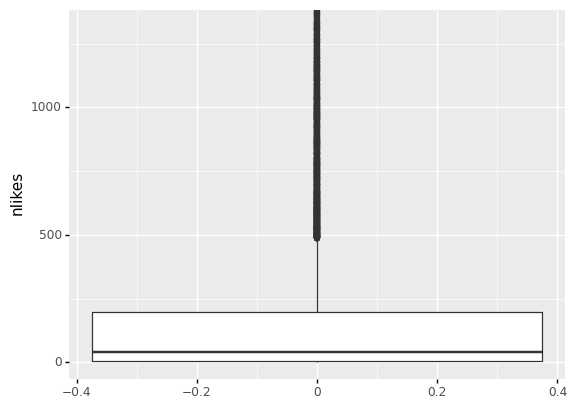

In [7]:
graph = (
    pn.ggplot(tweet_data, pn.aes(x='0', y='nlikes'))
    + pn.geom_boxplot()
    + pn.coord_cartesian(ylim=[0, tweet_data.nlikes.quantile(0.90)])
    + pn.xlab('')
)

graph.draw();

In [8]:
target = 'is_popular'
cutoff = 200
tweet_data[target] = (tweet_data.nlikes >= cutoff).astype(int)

tweet_data[target].value_counts(normalize=True, dropna=False) * 100

0    75.099184
1    24.900816
Name: is_popular, dtype: float64

## Las variables
Un punto muy fuerte de los modelos basados en arboles es que son muy robustos y capaces de manejar muchas variables. Por esto vamos a dedicar un poco de tiempo en crear nuevas variables.

In [9]:
# Tiene hashtags?
tweet_data['number_hashtags'] = tweet_data.hashtags.str.count(',')
tweet_data['num_replies_to'] = tweet_data.reply_to.str.count('{')
tweet_data['num_photos'] = tweet_data.photos.str.count(',')
tweet_data['num_urls'] = tweet_data.urls.str.count(',')


# Media de likes etc. para sus posts del pasado
tweet_data['avg_likes'] = tweet_data.likes / tweet_data.tweets
tweet_data['avg_media'] = tweet_data.media / tweet_data.tweets
tweet_data['followers_per_tweet'] = tweet_data.followers / tweet_data.tweets

# Otras cosas
tweet_data['user_name_equal_name'] = tweet_data.name.str.lower().str.replace(' ', '') == tweet_data.username
tweet_data['has_location'] = tweet_data.location.notna()
tweet_data['num_days_created'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(tweet_data.join_date)).dt.days
tweet_data['tweets_p_day'] = tweet_data.tweets / tweet_data.num_days_created
tweet_data['bio_length'] = tweet_data.bio.str.len()
tweet_data['tweet_length'] = tweet_data.tweet.str.len()

## Dividir train, test y analizar correlaciones

In [10]:
train, test = sklearn.model_selection.train_test_split(tweet_data, train_size=0.7, random_state=0)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

(28406, 70)
(12175, 70)


In [11]:
potential_variables = [
    'followers', 'following', 'video', 'retweet', 'tweets', 'likes', 'media', 'verified',
    'number_hashtags', 'num_replies_to', 'num_photos', 'num_urls', 'avg_likes', 'avg_media',
    'followers_per_tweet', 'user_name_equal_name', 'has_location', 'num_days_created',
    'tweets_p_day', 'bio_length', 'tweet_length'
]

for variable in potential_variables:
    print(f'For variable {variable}:')
    print(train.groupby(target)[variable].agg(['mean', 'sem']))
    print('\n')

For variable followers:
                    mean            sem
is_popular                             
0           7.530487e+06   66970.505890
1           1.700020e+07  210092.411983


For variable following:
                    mean          sem
is_popular                           
0           14431.596625  1337.837919
1            4573.778815   321.842591


For variable video:
                mean       sem
is_popular                    
0           0.180830  0.002635
1           0.370386  0.005743


For variable retweet:
                mean       sem
is_popular                    
0           0.202859  0.002753
1           0.000000  0.000000


For variable tweets:
                     mean          sem
is_popular                            
0           190333.078369  1005.550707
1           140349.329232  1777.049067


For variable likes:
                    mean         sem
is_popular                          
0           15862.967518  394.998123
1            8747.476877  329.09

In [12]:
train[potential_variables].isna().sum()

followers                 0
following                 0
video                     0
retweet                   0
tweets                    0
likes                     0
media                     0
verified                  0
number_hashtags           0
num_replies_to            0
num_photos                0
num_urls                  0
avg_likes                 0
avg_media                 0
followers_per_tweet       0
user_name_equal_name      0
has_location              0
num_days_created          0
tweets_p_day              0
bio_length              427
tweet_length              0
dtype: int64

In [13]:
(train.bio_length == 0).mean()

0.0

In [14]:
train['bio_length'] = train.bio_length.fillna(0)
test['bio_length'] = test.bio_length.fillna(0)

## Introducción a nuestros modelos
Vamos a empezar entrenando un arbol de decision para entender lo que hay por debajo de los arboles de decision.

In [15]:
numeric_variables = potential_variables
cat_variables = ['language']

cat_pipeline = sklearn.pipeline.Pipeline(
    [
        ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ('categorical', cat_pipeline, cat_variables),
        ('numeric', 'passthrough', numeric_variables)
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ('preprocessing', preprocessing),
        ('classifier', sklearn.tree.DecisionTreeClassifier(random_state=0))
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 1
pred_col = f'predictions_{model_no}'

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:,1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:,1]


In [16]:
pd.concat([
    train[target], train[f'predictions_{model_no}'], train[f'predictions_{model_no}'].round().astype(bool)
], axis=1)

,is_popular,predictions_1,predictions_1
0,0,0.0,False
1,0,0.0,False
2,0,0.0,False
3,1,1.0,True
4,0,0.0,False
...,...,...,...
28401,1,1.0,True
28402,0,0.0,False
28403,0,0.0,False
28404,0,0.0,False


In [17]:
auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

The auc in train is 0.995 and in test it is 0.853, the accuracies are 96.1% and 87.0%


Desde el primer momento los resultados no parecen malos - el modelo ha podido incorporar casi todos los datos y producir un resultado bastante bueno frente al baseline inicial de 75%. Pero si estamos atentos - vemos que hay una diferencia importante entre los resultados de train y test. Parece que existe algo de overfitting en nuestro ejemplo.

In [18]:
numeric_variables = potential_variables
cat_variables = ['language']

cat_pipeline = sklearn.pipeline.Pipeline(
    [
        ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ('categorical', cat_pipeline, cat_variables),
        ('numeric', 'passthrough', numeric_variables)
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ('preprocessing', preprocessing),
        ('classifier', sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=7, min_samples_leaf=5))
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 2
pred_col = f'predictions_{model_no}'

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:,1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:,1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')


The auc in train is 0.924 and in test it is 0.923, the accuracies are 86.5% and 86.0%


Vemos que cambiando unos parametros simples, somos capaces de quitar mucho de esta diferencia. Las claves para regular el overfitting con los modelos basados en arboles son:

* La profundidad del arbol `max_depth`
* El numero de ejemplos minimo en un nodo / split `min_samples_split`
* El numero de ejemplos minimo en un nodo final /  leaf `min_samples_leaf`

Hay más pero estos son los más faciles de entender e interpretar.

Otro beneficio de este tipo de modelo es que tenemos unas salidas del modelo adicionales - el arbol de decision en si y tambien la importancia de los features.

In [19]:
feature_names = train.language.sort_values().unique().tolist() + numeric_variables

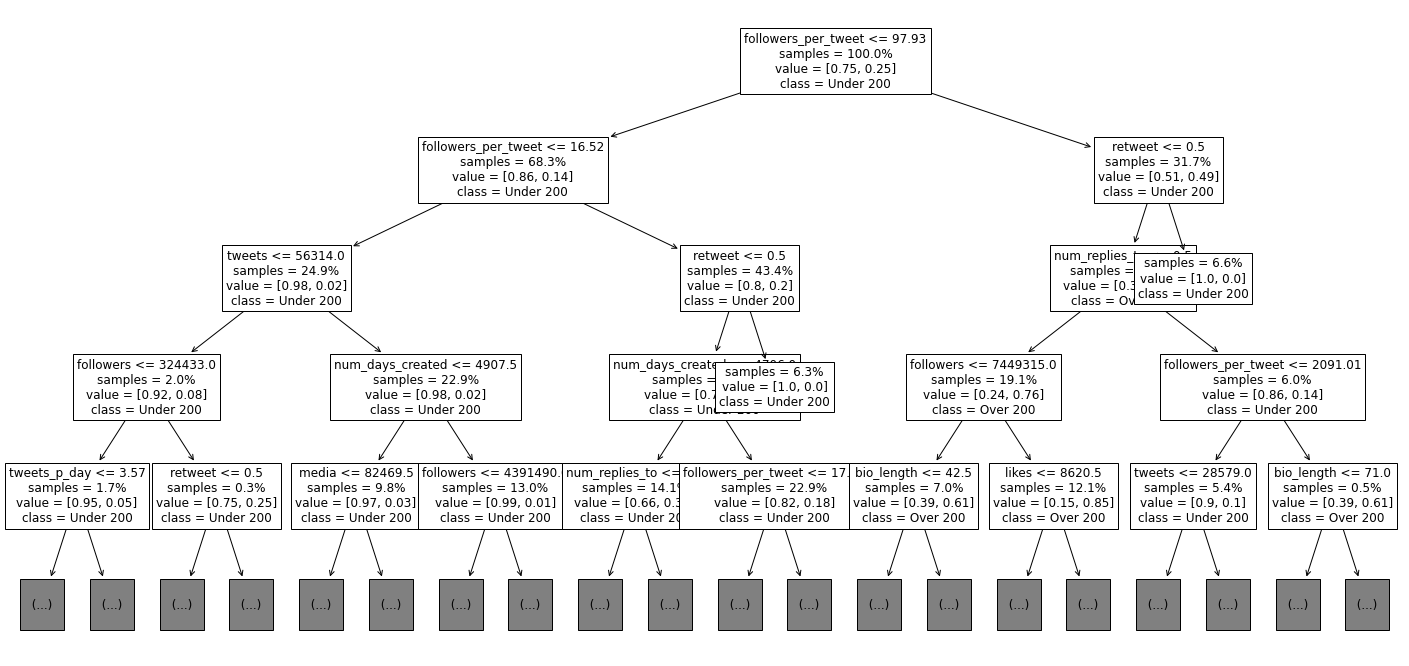

In [20]:
plt.figure(figsize=(25, 12))
sklearn.tree.plot_tree(
    full_pipeline['classifier'], fontsize=12, feature_names=feature_names, class_names=[f'Under {cutoff}', f'Over {cutoff}'], max_depth=4, 
    impurity=False, proportion=True, precision=2
)
plt.show()

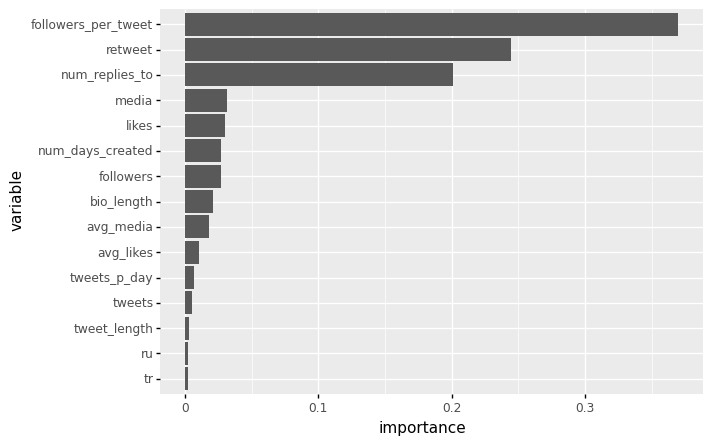

In [21]:
graph_data = pd.DataFrame(
    [(imp, variable) for imp, variable in zip(full_pipeline['classifier'].feature_importances_, feature_names)], 
    columns=['importance', 'variable']
).sort_values('importance', ascending=False)

limit = 15
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x='variable', y='importance')) 
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw();

Asi podemos entender exactamente que es lo que esta pasando por debajo de nuestro modelo - viendo que los followers por tweet es un feature muy importante.

## Random forest y XGBoost
Ahora vamos a intentar replicar lo que hemos hecho, pero utilizando 2 modelos más complejos: RandomForest y XGBoost. Para XGBoost vamos a utilizar otra libreria, pero como veremos, el sintaxis es igual.

In [22]:
numeric_variables = potential_variables
cat_variables = ['language']

cat_pipeline = sklearn.pipeline.Pipeline(
    [
        ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ('categorical', cat_pipeline, cat_variables),
        ('numeric', 'passthrough', numeric_variables)
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ('preprocessing', preprocessing),
        ('classifier', sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=500, max_depth=10, min_samples_leaf=5))
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 2
pred_col = f'predictions_{model_no}'

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:,1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:,1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')


The auc in train is 0.938 and in test it is 0.936, the accuracies are 88.4% and 87.8%


Vemos que hemos mejorado ligeramente y ahora hemos directamente utilizado los mismo parametros para regular el overfitting un poco.

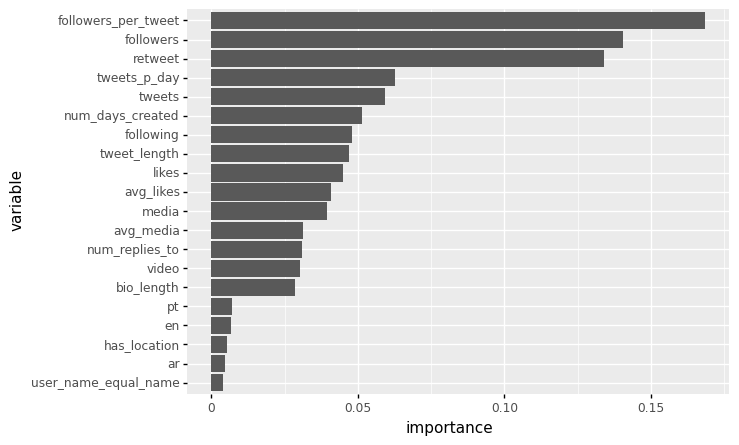

In [23]:
graph_data = pd.DataFrame(
    [(imp, variable) for imp, variable in zip(full_pipeline['classifier'].feature_importances_, feature_names)], 
    columns=['importance', 'variable']
).sort_values('importance', ascending=False)

limit = 20
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x='variable', y='importance')) 
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw();

Aunque no podemos visualizar el arbol de decision (tenemos 500!) podemos ver la importancia de las variables. Vemos que son relativamente similares, pero no tenemos resultados tan extremos como antes.

In [25]:
numeric_variables = potential_variables
cat_variables = ['language']

cat_pipeline = sklearn.pipeline.Pipeline(
    [
        ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ('categorical', cat_pipeline, cat_variables),
        ('numeric', 'passthrough', numeric_variables)
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ('preprocessing', preprocessing),
        ('classifier', xgboost.XGBClassifier(random_state=0, n_estimators=100, max_depth=7, min_samples_leaf=5))
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 3
pred_col = f'predictions_{model_no}'

full_pipeline.fit(train[X_variables], train[target])

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:,1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:,1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')


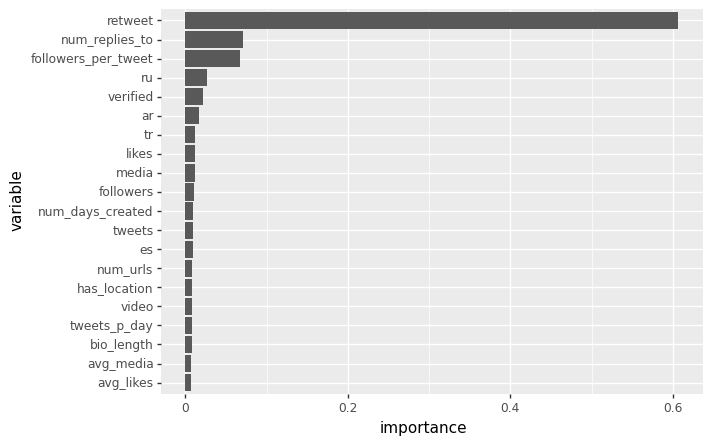

In [90]:
graph_data = pd.DataFrame(
    [(imp, variable) for imp, variable in zip(full_pipeline['classifier'].feature_importances_, feature_names)], 
    columns=['importance', 'variable']
).sort_values('importance', ascending=False)

limit = 20
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x='variable', y='importance')) 
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw();

Otra vez - vemos que hemos conseguido una mejora ligera pero ahora el over training parece mas dramatico. La importancia de las variables tambien ha cambiado, otra vez siendo mas extremo. No vamos a profundizar mucho más porque no es tan importante.

## Optimizando

In [25]:
full_pipeline = sklearn.pipeline.Pipeline(
    [
        ('preprocessing', preprocessing),
        ('classifier', sklearn.ensemble.RandomForestClassifier(random_state=0))
    ]
)

grid = {
    'classifier__n_estimators' : [100, 500],
    'classifier__max_depth' : [None, 5, 10],
    'classifier__min_samples_leaf' : [None, 5, 10],
    'classifier__min_samples_split' : [None, 5, 10]
}

optimized_pipeline = sklearn.model_selection.GridSearchCV(full_pipeline, grid)

#####

X_variables = numeric_variables + cat_variables
model_no = 4
pred_col = f'predictions_{model_no}'

optimized_pipeline.fit(train[X_variables], train[target])
train[pred_col] = optimized_pipeline.predict_proba(train[X_variables])[:,1]
test[pred_col] = optimized_pipeline.predict_proba(test[X_variables])[:,1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 441, in fit
    trees = Par

The auc in train is 0.963 and in test it is 0.948, the accuracies are 90.8% and 89.2%


In [26]:
optimized_pipeline.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 500}

## Comparando la utilidad real

In [27]:
results = []
renames = {0 : 'recall', 1 : 'precision', 2 : 'threshold'}
for i in range(1, 5):
    result = pd.DataFrame(sklearn.metrics.precision_recall_curve(test[target], test[f'predictions_{i}'])).transpose().rename(columns=renames)
    result['prediction_number'] = str(i)
    results.append(result)
    
results = pd.concat(results) 

KeyError: 'predictions_3'

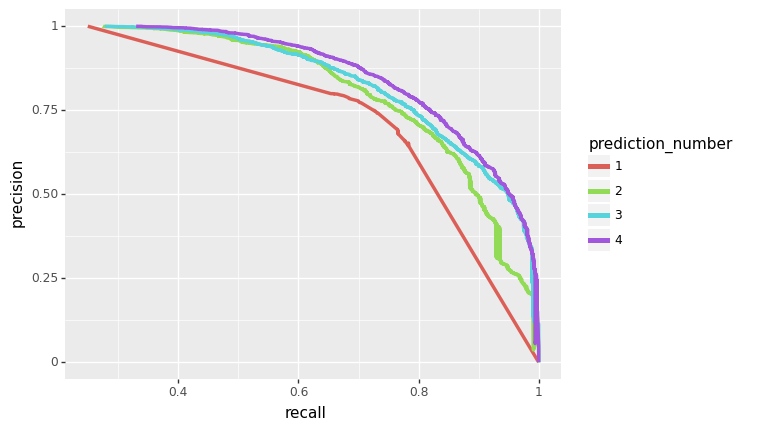

In [ ]:
graph = (
    pn.ggplot(results, pn.aes(x='recall', y='precision', color='prediction_number'))
    + pn.geom_line(size=1.4)
)

graph.draw();

Apreciamos que podemos conseguir unos resultados bastante mejor para el random forest y XGBoost - conseguimos un 0.4 de recall con asi 100% de precision por ejemplo.